In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from scipy.signal import butter, filtfilt, lfilter
import matplotlib.pyplot as plt
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import TimeDistributed, Reshape, Permute
from keras.utils import to_categorical
from tensorflow import keras
import pywt
import scipy.signal as signal
from scipy.integrate import simps

import scipy

In [ ]:
# ---------- FUNCTIONS ---------- #

#___SCALING___#
def apply_scaling(array):
  array_norm = np.zeros((array.shape[0],array.shape[1]))
  for i in range(array.shape[0]):
    means = np.mean(array[i])  # Calculate mean for each sensor
    stds = np.std(array[i])    # Calculate standard deviation for each sensor
    array_norm[i] = (array[i] - means) / stds   # Subtrack and divide

  del array, means, stds
  gc.collect()
  return array_norm

#___LOWPASS FILTER___#
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def apply_lowpass(array):
  original_sampling_rate = 2034  # Original sampling rate
  downsampling_factor = 4
  new_sampling_rate = original_sampling_rate / downsampling_factor  # New sampling rate after downsampling
  cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency

  array_filtered = np.zeros((array.shape[0], array.shape[1]))

  for i in range(array.shape[0]):  # Iterate over sensors
      array_filtered[i, :] = butter_lowpass_filter(array[i, :], cutoff_frequency, original_sampling_rate)

  del array
  return array_filtered

#___DOWNSAMPLING___#
def apply_downsampling(array):
  n_sensors, n_timepoints = array.shape

  downsampling_factor = 4
  new_n_timepoints = n_timepoints // downsampling_factor
  array_downsamp = np.zeros((n_sensors, new_n_timepoints))

  for sensor in range(n_sensors):
    array_downsamp[sensor,:] = array[sensor, ::downsampling_factor]

  del array, new_n_timepoints, downsampling_factor, n_sensors, n_timepoints
  gc.collect()
  return array_downsamp


#___BANDS AND STATS___#
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    y = scipy.signal.filtfilt(b, a, data)
    return y


def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    y = scipy.signal.filtfilt(b, a, data)
    return y

def extract_frequency_bands(data, fs):
    # Define the frequency bands
    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'gamma': (30, 80)}

    # Initialize the output
    extracted_features = np.zeros((data.shape[0], 25))  # 248 sensors, 5 bands * 5 features
    band_signals_visual = np.zeros((data.shape[0], 5, data.shape[1]))
    for sensor_index in range(data.shape[0]):
        sensor_data = data[sensor_index, :]

        features = []
        bands_visual = []
        for band in bands.values():
            # Apply bandpass filter
            band_data = bandpass_filter(sensor_data, band[0], band[1], fs=fs)
            bands_visual.append(band_data)

            # Calculate statistical features
            features.append(np.mean(band_data))
            features.append(np.std(band_data))
            features.append(scipy.stats.skew(band_data))
            features.append(scipy.stats.kurtosis(band_data))
            features.append(np.sum(np.square(band_data)))  # Energy

        extracted_features[sensor_index, :] = features
        band_signals_visual[sensor_index] = np.array(bands_visual)

    return extracted_features, band_signals_visual


In [ ]:
# LOAD FILES

def get_file_paths_and_labels(data_folder, task_numbers):
  file_paths = []
  labels = []
  for task_number in task_numbers:
      for file in os.listdir(data_folder):
          if file.endswith(task_number + 'h5'):
              file_path = os.path.join(data_folder, file)
              file_paths.append(file_path)
              labels.append(assign_label(file))
  return file_paths, labels

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/train')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def load_data(file_path):
  with h5py.File(file_path, 'r') as f:
      dataset_name = get_dataset_name(file_path)
      matrix = f.get(dataset_name)[:]
      return matrix

def get_dataset_name(file_name_with_dir):
  filename_without_dir = file_name_with_dir.split('/')[-1]
  temp = filename_without_dir.split('_')[:-1]
  dataset_name = "_".join(temp)
  return dataset_name

def assign_label(file_name):
  if file_name.startswith("rest"):
      return 0
  elif file_name.startswith("task_motor"):
      return 1
  elif file_name.startswith("task_story"):
      return 2
  elif file_name.startswith("task_working"):
      return 3
  else:
      return None

def count_files_with_task_numbers(data_folder, task_numbers):
    total_files = 0
    for file in os.listdir(data_folder):
        if any(file.endswith(task_number + 'h5') for task_number in task_numbers):
            total_files += 1
    return total_files

In [ ]:
# ----- MODEL ----- #

def build_ffnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))  # Flatten the input
    model.add(Dense(64, activation='relu'))  # First hidden layer
    # model.add(Dropout(0.5))  # Dropout layer for regularization
    model.add(Dense(128, activation='relu'))  # Second hidden layer
    # model.add(Dropout(0.5))  # Another dropout layer
    model.add(Dense(num_classes, activation='softmax'))  # Output layer

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
############################################################################
# ------------------------------ Train Data ------------------------------ #
############################################################################

In [ ]:
# Call Preprocessing functions
def preprocess_data(data, i):
  print(f"*** FILE {i} ***")
  data = data[:, :-8]
  data = apply_scaling(data)
  print("scaling applied: shape:", data.shape, end=', ')
  data = apply_lowpass(data)
  print("lowpass applied: shape:", data.shape, end=', ')
  data = apply_downsampling(data)
  print("downsam applied: shape:", data.shape, end=', ')
  bands_data, bands_visual = extract_frequency_bands(data, 2034/12)
  print("Data after extracting features:", np.array(bands_data).shape)
  del data
  return np.array(bands_data), bands_visual


In [ ]:
# Retieve the initial data from the folder

fmri_data_folder = find_fmri_data_folder('/content/drive')
print("fmri_data_folder:", fmri_data_folder)

meg_data_list = []
labels = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_data_list.append(data)
        labels.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_train_data_array = np.stack(meg_data_list, axis=0)
labels_train_array = np.array(labels)

del meg_data_list, labels

fmri_data_folder: /content/drive/MyDrive/Courses/Pattern Recognition/Lab/Group Assignment/meg_data/Intra/train


In [ ]:
print("## Initial shapes of the data ##")
print("MEG:", meg_train_data_array.shape)
print("Labels:",labels_train_array.shape)

## Initial shapes of the data ##
MEG: (32, 248, 35624)
Labels: (32,)


In [ ]:
processed_data_example = np.zeros((meg_train_data_array.shape[0], meg_train_data_array.shape[1], 25))
bands_visual_example = np.zeros((meg_train_data_array.shape[0], meg_train_data_array.shape[1], 5, 8904))

processed_data_example[0], bands_visual_example[0] = preprocess_data(meg_train_data_array[0], 1)

*** FILE 1 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)


In [ ]:
bands_visual_example.shape

(32, 248, 5, 8904)

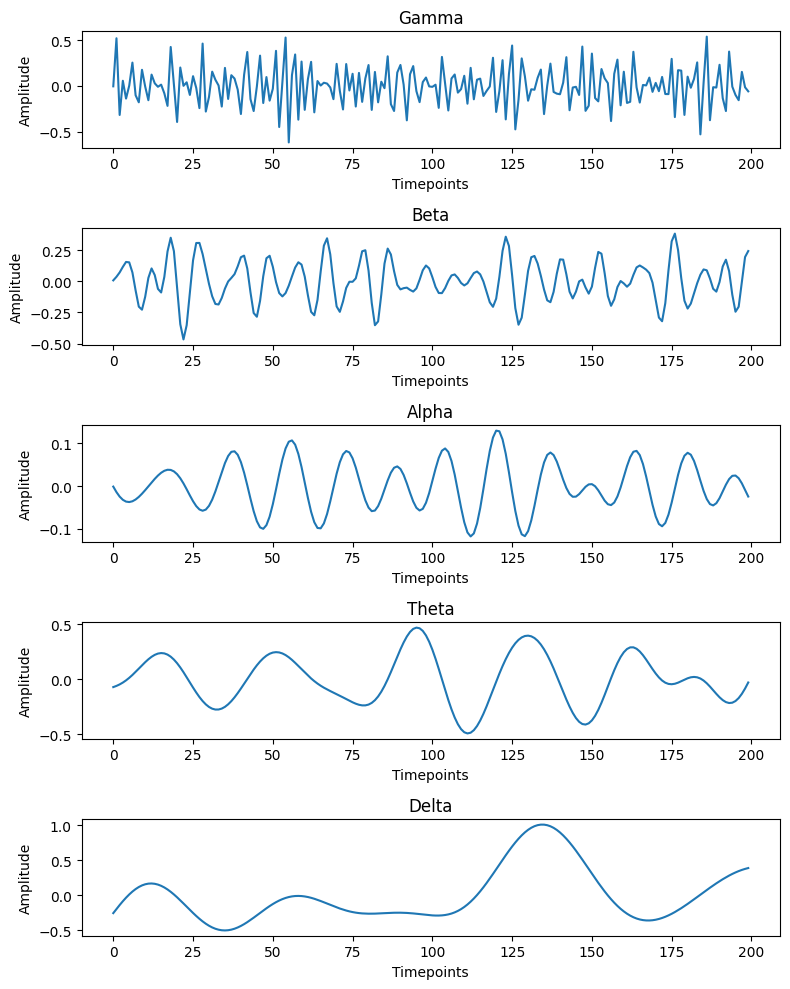

In [ ]:
# Visualize the signal of the first sensor after each step
import matplotlib.pyplot as plt

# Assuming each array is a NumPy array and the first sensor's data is the first row
# Example: raw_data[0, :], scaled_data[0, :], etc.

plt.figure(figsize=(8, 10))

plt.subplot(5, 1, 1)  # 4 rows, 1 column, 4th subplot
plt.plot(bands_visual_example[0][0][4][:200], label='Gamma')
plt.title('Gamma')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')

plt.subplot(5, 1, 2)  # 4 rows, 1 column, 4th subplot
plt.plot(bands_visual_example[0][0][3][:200], label='Beta')
plt.title('Beta')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')

plt.subplot(5, 1, 3)  # 4 rows, 1 column, 3rd subplot
plt.plot(bands_visual_example[0][0][2][:200], label='Alpha')
plt.title('Alpha')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')

plt.subplot(5, 1, 4)  # 4 rows, 1 column, 2nd subplot
plt.plot(bands_visual_example[0][0][1][:200], label='Theta')
plt.title('Theta')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')

plt.subplot(5, 1, 5)  # 4 rows, 1 column, 1st subplot
plt.plot(bands_visual_example[0][0][0][:200], label='Delta')
plt.title('Delta')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')




plt.tight_layout()
plt.show()


In [ ]:
# ----- CALL PROCESSING FUNCTIONS FOR ALL FILES ----- #

processed_data = np.zeros((meg_train_data_array.shape[0], meg_train_data_array.shape[1], 25))
print(processed_data.shape)
for i in range(meg_train_data_array.shape[0]):
  processed_data[i] = preprocess_data(meg_train_data_array[i], i+1)

(32, 248, 25)
*** FILE 1 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 2 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 3 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 4 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 5 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 6 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data aft

In [ ]:
# ----- FLATTEN THE DATA AND REPEAT THE LABELS ----- #
processed_data_flat = processed_data.reshape(-1,25)

labels_expanded = np.repeat(labels_train_array, 248, axis=0)
labels_expanded = to_categorical(labels_expanded, num_classes=4)

X_train = processed_data_flat
y_train = labels_expanded

del processed_data_flat, labels_expanded, labels_train_array, processed_data, meg_train_data_array

In [ ]:
print("## Final shapes of the data ##")
print("MEG:", X_train.shape)
print("Labels:",y_train.shape)

## Final shapes of the data ##
MEG: (7936, 25)
Labels: (7936, 4)


In [ ]:
# ----- TRAINING THE MODEL ----- #

model = build_ffnn_model(input_shape=(25, 1), num_classes=4)

history = model.fit(
    X_train, y_train,
    epochs=400,
    batch_size=32,
)

Epoch 1/400
248/248 [==============================] - 1s 2ms/step - loss: 16.2294 - accuracy: 0.2755
Epoch 2/400
248/248 [==============================] - 0s 2ms/step - loss: 5.7080 - accuracy: 0.2923
Epoch 3/400
248/248 [==============================] - 0s 2ms/step - loss: 6.1843 - accuracy: 0.2980
Epoch 4/400
248/248 [==============================] - 0s 2ms/step - loss: 5.3486 - accuracy: 0.3063
Epoch 5/400
248/248 [==============================] - 0s 2ms/step - loss: 4.0891 - accuracy: 0.3096
Epoch 6/400
248/248 [==============================] - 0s 2ms/step - loss: 4.0346 - accuracy: 0.3144
Epoch 7/400
248/248 [==============================] - 0s 2ms/step - loss: 3.4715 - accuracy: 0.3154
Epoch 8/400
248/248 [==============================] - 0s 2ms/step - loss: 3.1812 - accuracy: 0.3209
Epoch 9/400
248/248 [==============================] - 0s 2ms/step - loss: 4.2198 - accuracy: 0.3148
Epoch 10/400
248/248 [==============================] - 0s 2ms/step - loss: 3.2809 - accur

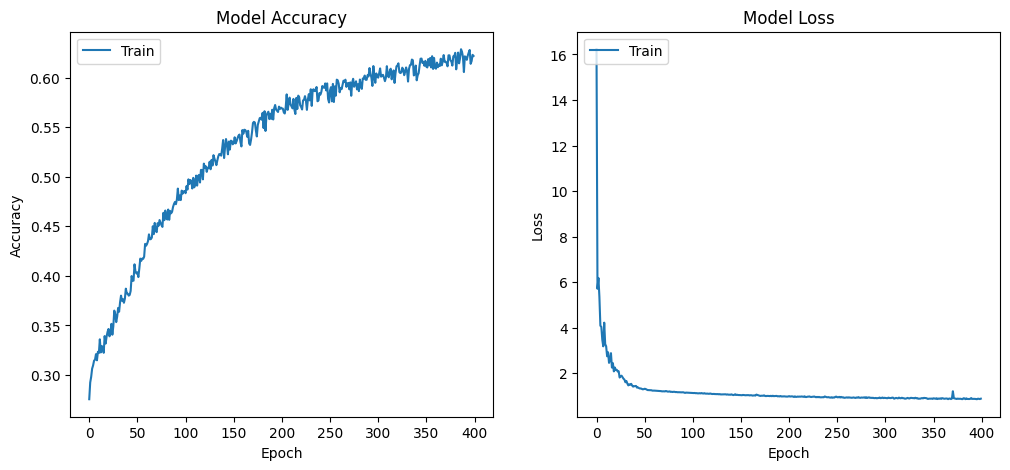

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.show()


In [ ]:
############################################################################
# ------------------------------ Test Data ------------------------------ #
############################################################################

In [ ]:
# ----- RETRIEVE TEST DATA ----- #

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/test')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

def assign_label(file_name):
    if file_name.startswith("rest"):
        return 0
    elif file_name.startswith("task_motor"):
        return 1
    elif file_name.startswith("task_story"):
        return 2
    elif file_name.startswith("task_working"):
        return 3
    else:
        return None

def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_name = get_dataset_name(file_path)
        matrix = f.get(dataset_name)[:]
        return matrix

fmri_data_folder = find_fmri_data_folder('/content/drive')
meg_test_data_list = []
labels_test = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_test_data_list.append(data)
        labels_test.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_test_data_array = np.stack(meg_test_data_list, axis=0)
labels_test_array = np.array(labels_test)

print("## Initial shapes of the test data ##")
print(meg_test_data_array.shape)
print(labels_test_array.shape)

## Initial shapes of the test data ##
(8, 248, 35624)
(8,)


In [ ]:
# ----- CALLING THE PROCESSING FUNCTION ----- #

processed_data = np.zeros((meg_test_data_array.shape[0], meg_test_data_array.shape[1], 25))
print(processed_data.shape)
for i in range(meg_test_data_array.shape[0]):
  processed_data[i] = preprocess_data(meg_test_data_array[i], i+1)

(8, 248, 25)
*** FILE 1 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 2 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 3 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 4 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 5 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 6 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data afte

In [ ]:
# ----- FLATTEN THE DATA AND REPEAT THE LABELS ----- #

processed_data_flat = processed_data.reshape(-1,25)

labels_expanded = np.repeat(labels_test_array, 248, axis=0)
labels_expanded = to_categorical(labels_expanded, num_classes=4)

X_test = processed_data_flat
y_test = labels_expanded

del processed_data_flat, labels_expanded

In [ ]:
print("## Data after processing ##")
print("MEG:", X_test.shape)
print("Labels:", y_test.shape)

## Data after processing ##
MEG: (1984, 25)
Labels: (1984, 4)


In [ ]:
# TEST EACH SENSOR INDEPENDENTLY

test_loss, test_accuracy = model.evaluate(X_test, y_test)

62/62 [==============================] - 0s 2ms/step - loss: 1.9400 - accuracy: 0.4491


In [ ]:
import numpy as np

# Make predictions for the entire test set. They are in one-hot-vector form.
all_predictions = model.predict(X_test)

# Convert predictions to class labels (0, 1, 2, 3)
predicted_labels_all = np.argmax(all_predictions, axis=1)

# Aggregate predictions for each original test instance
# For every 248 predictions keep the most frequent one (that represents the each total file's prediction)
final_predictions = []
proportions = []
for i in range(0, len(predicted_labels_all), 248):  # Iterate over each set of 248 sensors (step=248)
    # Get the predictions for the current set of sensors
    sensor_predictions = predicted_labels_all[i:i + 248]
    print(sensor_predictions)

    unique, counts = np.unique(sensor_predictions, return_counts=True)
    print("\n",dict(zip(unique, counts)))

    # Find the most frequent prediction
    most_frequent_prediction = np.argmax(np.bincount(sensor_predictions))
    print("MOST FREQUENT:", most_frequent_prediction)

    # Find the proportion of this prediction compared to all the other labels
    proportion = np.max(np.bincount(sensor_predictions)) / 248
    print(f"PROPORTION: {(proportion*100):.2f}%")
    proportions.append(proportion)

    print("_____________________________________________________________________________________________")
    final_predictions.append(most_frequent_prediction)

62/62 [==============================] - 0s 2ms/step
[3 2 2 0 3 3 1 1 1 2 3 1 0 3 0 2 3 1 1 3 2 2 0 2 2 0 0 1 1 0 0 1 0 1 2 0 2
 0 1 1 0 1 1 3 0 1 3 2 3 1 0 2 0 0 3 3 2 0 0 2 2 1 0 1 0 1 0 1 0 1 1 2 3 1
 3 3 3 3 2 3 0 0 0 3 0 2 2 2 2 2 1 0 0 3 0 2 2 0 2 1 1 2 2 2 1 0 2 1 2 0 1
 2 0 1 1 1 3 3 2 2 0 2 3 1 3 3 2 0 0 1 2 1 3 0 2 2 2 2 1 2 2 2 1 2 0 0 0 2
 0 1 1 1 0 3 3 0 3 3 1 0 0 1 3 2 3 3 0 1 3 2 1 1 2 0 2 0 3 2 1 2 3 2 0 3 3
 1 3 1 0 1 0 2 0 1 2 1 2 3 2 1 0 0 0 2 2 3 0 1 2 0 3 2 0 1 0 1 0 1 0 1 3 1
 1 1 3 0 2 0 2 2 2 0 2 0 0 0 1 3 1 0 1 0 3 0 3 0 2 1]

 {0: 71, 1: 64, 2: 66, 3: 47}
MOST FREQUENT: 0
PROPORTION: 28.63%
_____________________________________________________________________________________________
[2 1 3 1 0 2 3 3 0 0 1 0 0 2 1 3 0 1 1 3 2 0 3 2 3 3 3 1 3 0 1 3 1 3 0 3 2
 3 3 0 3 3 3 3 0 1 3 0 3 3 0 3 0 0 1 1 2 0 1 3 3 3 1 3 3 2 0 3 1 3 3 3 1 3
 1 3 2 1 2 3 0 3 0 1 2 3 3 3 2 0 1 0 2 1 0 2 3 3 3 1 3 3 1 2 3 1 1 3 3 3 1
 1 3 3 1 3 0 0 0 2 3 2 1 1 3 0 0 2 3 0 3 0 3 0 2 1 0 3 3 

In [ ]:
print("FINAL PREDICTIONS (TOP), ACTUAL LABELS (BOTTOM)")
print(final_predictions)
print(list(labels_test_array))
print()
# Calculate accuracy or other metrics if needed
correct_predictions = np.sum(np.array(final_predictions) == labels_test_array)
accuracy = correct_predictions / len(final_predictions)
print("Aggregated Accuracy:", accuracy)

FINAL PREDICTIONS (TOP), ACTUAL LABELS (BOTTOM)
[0, 3, 2, 2, 1, 0, 3, 0]
[1, 3, 2, 2, 1, 0, 3, 0]

Aggregated Accuracy: 0.875


In [ ]:
# Print individual comparisons
for i in range(len(labels_test_array)):
    print(f"File {i}: Actual Label = {labels_test_array[i]}, Aggregated Predicted Label = {final_predictions[i]}")

File 0: Actual Label = 1, Aggregated Predicted Label = 0
File 1: Actual Label = 3, Aggregated Predicted Label = 3
File 2: Actual Label = 2, Aggregated Predicted Label = 2
File 3: Actual Label = 2, Aggregated Predicted Label = 2
File 4: Actual Label = 1, Aggregated Predicted Label = 1
File 5: Actual Label = 0, Aggregated Predicted Label = 0
File 6: Actual Label = 3, Aggregated Predicted Label = 3
File 7: Actual Label = 0, Aggregated Predicted Label = 0


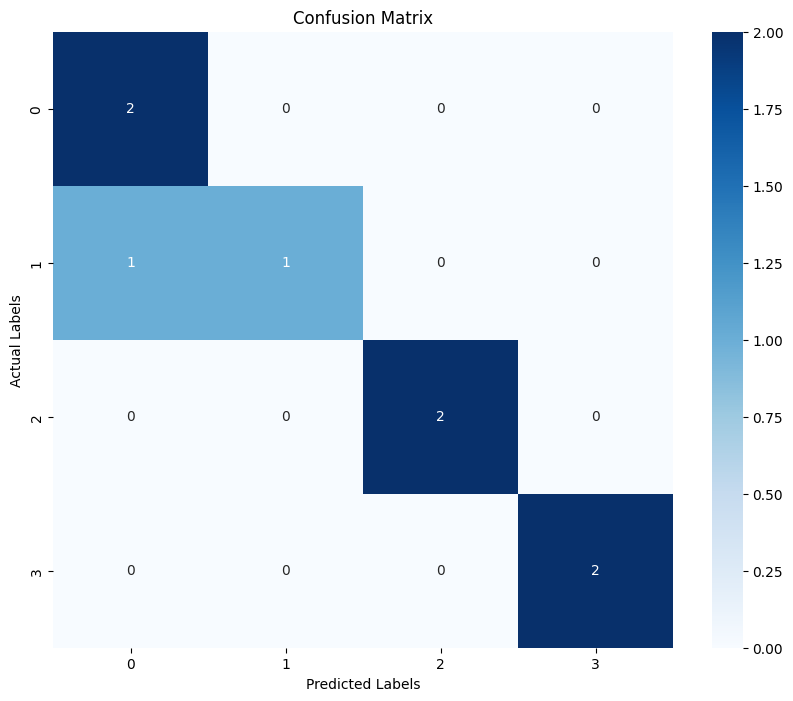

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(labels_test_array, final_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()
